# Домашнее задание №5: «Индейцы пима, диабет и линейный классификатор»

## Data

In [1]:
import numpy as np


def read_data(path_to_data_file):
    """
    Reading data from the file, a then splitting it into
    a features table and correct answers vector. 
    :param path_to_data_file: realtive path to data file
    :return: tuple of a features table and answers vector
    """
    raw_data = np.genfromtxt(path_to_data_file, delimiter=',')
    X = np.hstack((-np.ones(raw_data.shape[0])[None].T, raw_data[:, :-1]))
    y = -2 * raw_data[:, -1] + 1
    return X, y

In [2]:
def data_standartization(X):
    mean = X.mean(axis=0)
    mean[0] = 0
    dispersion = np.std(X, axis=0)
    dispersion[dispersion == 0] = 1
    return (X - mean) / dispersion


def data_scaling_to_unit_lenght(X):
    normL2 = np.linalg.norm(X, axis=0) 
    normL2[0] = 1
    normL2[normL2 == 0] = 1
    return X / normL2

In [3]:
PAHT_TO_DATA_FILE = "pima-indians-diabetes.csv"


X, y = read_data(PAHT_TO_DATA_FILE)
X = data_standartization(X)

## Losses functions

In [4]:
import math
from scipy import special


def log_loss(M):
    return np.logaddexp(0, -M) / math.log(2), -special.expit(-M) / math.log(2)


def sigmoid_loss(M):
    sigmoid = special.expit(-M)
    return 2 * sigmoid, -2 * sigmoid * (1 - sigmoid)

## Gradient descent

In [5]:
class GradientDescent:
    def __init__(self, *, alpha=1, threshold=1e-5, loss=sigmoid_loss):
        if alpha <= 0:
            raise ValueError("alpha should be positive!")
        if threshold <= 0:
            raise ValueError("threshold should be positive!")

        self.alpha = alpha
        self.threshold = threshold
        self.loss = loss
        self.weights = None

    def fit(self, X, y):
        n, m = X.shape
        Xy = X * y[None].T
        prev_weights = None
        self.weights = np.random.uniform(-1. / (2 * m), 1. / (2 * m), m)
        errors = []
        while prev_weights is None or np.linalg.norm(self.weights - prev_weights) >= self.threshold:
            M = Xy @ self.weights
            quality, quality_deriative = self.loss(M)
            prev_weights = self.weights.copy()
            self.weights -= self.alpha * (quality_deriative @ Xy)
            errors.append(quality.sum())
        return np.array(errors)

    def predict(self, X):
        return 2 * (X @ self.weights >= 0) - 1

## SGD

In [6]:
class SGD:
    def __init__(self, *, alpha, loss=log_loss, k=1, n_iter=10000):
        if alpha <= 0:
            raise ValueError("alpha should be positive!")
        if k <= 0 or not isinstance(k, int):
            raise ValueError("k should be positive integer!")
        if n_iter <= 0 or not isinstance(n_iter, int):
            raise ValueError("n_iter should be a positive interger!")

        self.alpha = alpha
        self.loss = loss
        self.k = k
        self.n_iter = n_iter
        self.weights = None

    def fit(self, X, y):
        n, m = X.shape
        perm = np.random.permutation(n)
        X, y = X[perm], y[perm]
        Xy = X * y[None].T
        self.weights = np.random.uniform(-1. / (2 * m), 1. / (2 * m), m)
        errors = [self.loss(Xy @ self.weights)[0].sum()]
        for _ in range(self.n_iter):
            Xy_sample = Xy[np.random.choice(n, self.k, replace=False)]
            M = Xy_sample @ self.weights
            quality, quality_deriative = self.loss(M)
            self.weights -= self.alpha * (quality_deriative @ Xy_sample)
            errors.append((1 - 1. / n) * errors[-1] + (1. / n) * quality.sum())
        return np.array(errors)

    def predict(self, X):
        return 2 * (X @ self.weights >= 0) - 1

## Results

In [7]:
from sklearn.model_selection import train_test_split


TEST_RATIO=0.2


def precision_recall(y_pred, y_test, n_class):
    tp = ((y_pred == n_class) & (y_test == n_class)).sum()
    fp = ((y_pred == n_class) & (y_test != n_class)).sum()
    fn = ((y_pred != n_class) & (y_test == n_class)).sum()
    return tp / (tp + fp), tp / (tp + fn)


def print_precision_recall(y_pred, y_test):
    for n_class in [-1, 1]:
        print("Class {0}: Precision: {1[0]}, Recall: {1[1]}"
              .format(n_class, precision_recall(y_pred, y_test, n_class)))


def test(classificator):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO)
    classificator.fit(X_train, y_train)
    print(classificator.__class__.__name__)
    print_precision_recall(classificator.predict(X_test), y_test)

In [8]:
test(GradientDescent(alpha=1e-5))
test(SGD(alpha=1e-4, k=50))

GradientDescent
Class -1: Precision: 0.7777777777777778, Recall: 0.6481481481481481
Class 1: Precision: 0.8256880733944955, Recall: 0.9


SGD
Class -1: Precision: 0.65625, Recall: 0.42
Class 1: Precision: 0.7622950819672131, Recall: 0.8942307692307693


## Plots

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, RadioButtons
from itertools import product

### Gradient descent (sigmoid loss)

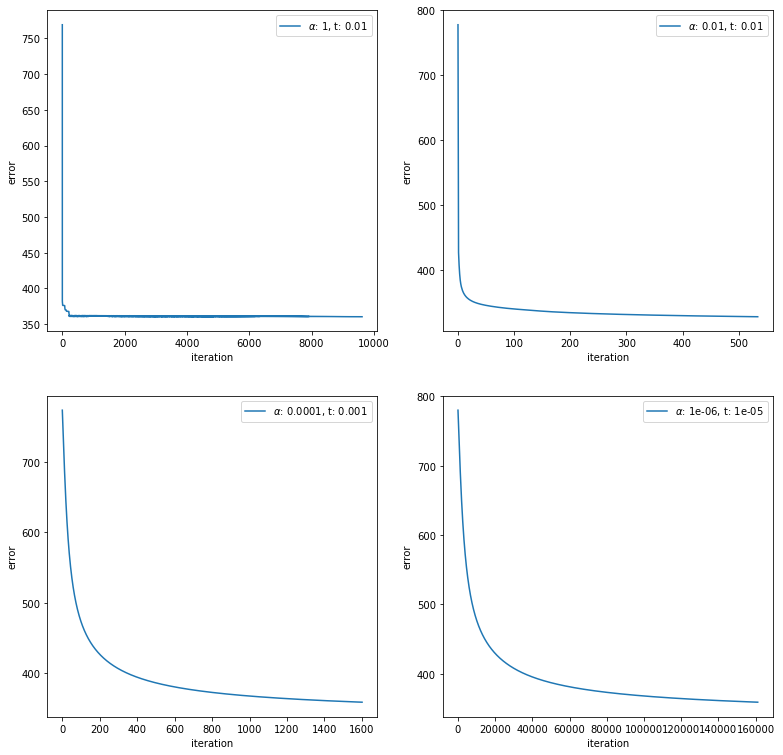

In [10]:
the_alphas = [1, 1e-2, 1e-4, 1e-6]
the_thresholds = [1e-2, 1e-2, 1e-3, 1e-5]

# plt.rcParams["figure.figsize"] = (14, 14)
# for a, t in zip(the_alphas, the_thresholds):
#     plt.plot(GradientDescent(alpha=a, threshold=t).fit(X, y), label=r"$\alpha$" + ": {}, t: {}".format(a, t))
# plt.legend(prop={"size": 14})

figs, axes = plt.subplots(nrows=2, ncols=2)
figs.set_figheight(13)
figs.set_figwidth(13)
for i, (a, t) in enumerate(zip(the_alphas, the_thresholds)):
    axis = axes.ravel()[i] 
    axis.plot(GradientDescent(alpha=a, threshold=t).fit(X, y), label=r"$\alpha$" + ": {}, t: {}".format(a, t))
    axis.set_xlabel("iteration")
    axis.set_ylabel("error")
    axis.legend()

### SGD (log loss)

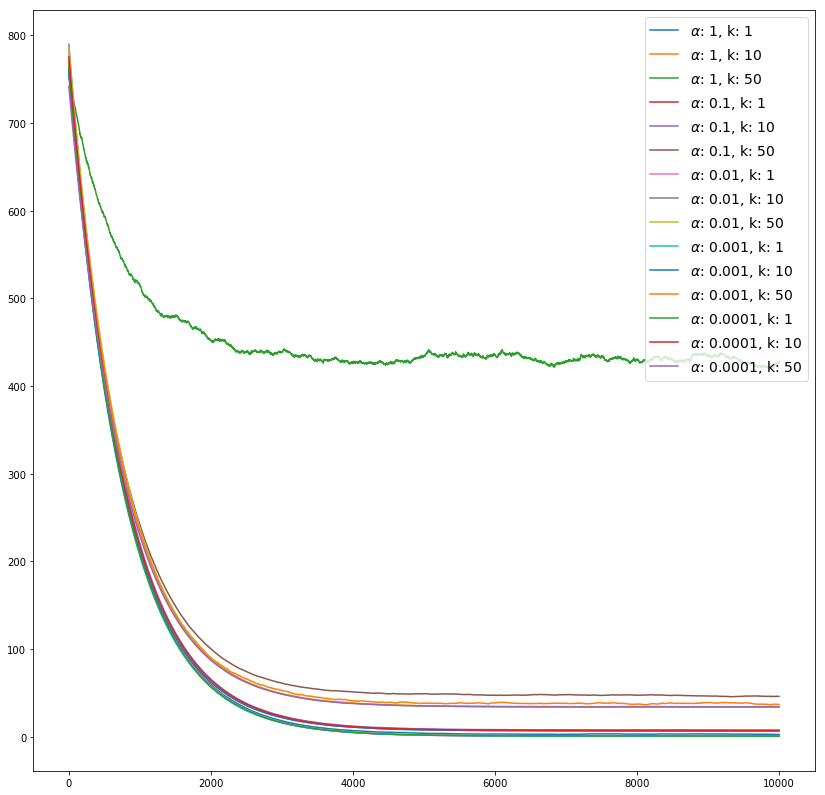

In [11]:
the_alphas = [10 ** (-k) for k in range(5)]
the_ks = [1, 10, 50]

# figs, axes = plt.subplots(nrows=len(ALPHA), ncols=len(K))
# figs.set_figheight(13)
# figs.set_figwidth(13)
# for (i, a), (j, k) in product(enumerate(ALPHA), enumerate(K)):
#     axes[i][j].plot(SGD(alpha=a, k=k, loss=log_loss).fit(X, y))

plt.rcParams["figure.figsize"] = (14, 14)
for a, k in product(the_alphas, the_ks):
    plt.plot(SGD(alpha=a, k=k).fit(X, y), label=r"$\alpha$" + ": {}, k: {}".format(a, k))
plt.legend(prop={"size": 14})

## Q&A

* **Почему функционал качества убывает в процессе работы градиентного спуска?
Почему это не всегда так для стохастического градиентного спуска?**

	Потому, что мы движемся в направлении его локального максимума. Для стохастического градиента, мы движемся в направлении локального максимума функционала для подвыборки иходной, которое не всегда совпадает с направлением для всей исходной выборки.

* **Как зависит скорость сходимости (количество итераций) алгоритмов от $\alpha$?**

	В среднем, большой $\alpha$ увеличивает скорость сходимости. Это логично: больше шаг, меньше придется ходить.

* **Как параметр $k$ влияет на поведение $Q$ в алгоритме стохастического градиентного спуска?**

	В целом, с большим $k$ мы больше рискуем выбрать случайную выборку, которая приведет нас к локальной яме, так не попадя в глобальный минимум. Но с маленьким k такие движения становятся слишком хаотичными. Конкретно на этой выборке - все сходися равно (кроме $\alpha=1, ~ k=50$).

* **Какие значения параметров каждого алгоритма вам кажутся оптимальными для задачи диагностики диабета? Почему?**

	Судя по графикам, быстро сходится, например, вариант с $\alpha=1e-4 k = 1$ и стохастическим градиентным спуском. Для обычного спуску, судя по precision и recall, хорошо приближаются к $0.8$ правильных ответов варианты с $\alpha=0.1$.

* **Как ведёт себя вектор весов $w$ при повторных запусках алгоритмов? Объясните причины наблюдаемого поведения.**

	Обычный: критерий останова - стабилизация $w$, поэтому вектор весов больше не изменяется. Стохастический: на текущих данных, за первые $3000$ мы успеваеем более-менее сойтись к какому-то значению, тем не менее, из-за случайности и влиянию начального $Q$, мы можем продолжать мизменять $w$.

* **Какой алгоритм уместнее использовать для данных индейцев пима? Почему?**

	Стохаскческий градиентный спуск нужен для того, чтобы не попадать в локальные ямки. Судя по графикам, их нету, поэтому по скорости и точности сойдет и обычный.

* **Приведите наиболее симпатичный вам вектор весов $w$ и дайте интерпретацию его значениями применительно к задаче диагностики диабета или объясните, почему это невозможно.**

	$w = [-0.81730139, -0.5524395, -1.22022049, 0.27383764, -0.01852351, 0.2166263, -0.62977274, -0.32313034, -0.12909864]$
	
	Первый вес соответствует константному признаку $-1$, поэтому это просто порог принятия решения. Абсолютные значения весов остальных можно просто интерпретировать как важность того или иного признака для классификации (так как это значения для нормированных данных). Скажем, Plasma glucose concentration a 2 hours in an oral glucose tolerance test влияет на ответ больше, чем Diastolic blood pressure.